In [1]:
using Revise

In [2]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using Flux
using ProgressMeter
using MLDataPattern
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models
using DataFrames

ArgumentError: Module Hiccup not found in current path.
Run `Pkg.add("Hiccup")` to install the Hiccup package.


In [3]:
robot = BoxAtlas()
mvis = MechanismVisualizer(robot)
IJuliaCell(mvis)

Listening on 127.0.0.1:7004...
zmq_url=tcp://127.0.0.1:6004
web_url=http://127.0.0.1:7004/static/


MeshCat.IJuliaCell(MeshCat.ViewerWindow(ZMQ.Context(Ptr{Void} @0x0000000006b24860, WeakRef[WeakRef(ZMQ.Socket(Ptr{Void} @0x0000000006afcd70, Base.Filesystem._FDWatcher(Ptr{Void} @0x0000000006b48fa0, 80, (1, 0), Condition(Any[]), (false, false), 0)))]), ZMQ.Socket(Ptr{Void} @0x0000000006afcd70, Base.Filesystem._FDWatcher(Ptr{Void} @0x0000000006b48fa0, 80, (1, 0), Condition(Any[]), (false, false), 0)), "http://127.0.0.1:7004/static/", "tcp://127.0.0.1:6004", MeshCat.ZMQServer.ZMQWebSocketBridge(ip"127.0.0.1", Set{WebSockets.WebSocket}(), MeshCat.SceneTrees.SceneNode(Nullable{Array{UInt8,1}}(), Nullable{Array{UInt8,1}}(), Dict("meshcat"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x68, 0xa8, 0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74], Dict("world"=>MeshCat.SceneTrees.SceneNode(#NULL, #NULL, Dict("root"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x77, 0x6f, 0x72, 0x6c, 0x64, 0x2f, 0x72, 0x6f, 0x6f, 0x74], Dict("floor"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x6f, 0x74, 0x2f, 0x66, 0x6c, 0x6f, 0x6f, 0x72], Dict("wall"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x66, 0x6c, 0x6f, 0x6f, 0x72, 0x2f, 0x77, 0x61, 0x6c, 0x6c], Dict("after_floor_to_wall"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x72, 0x5f, 0x74, 0x6f, 0x5f, 0x77, 0x61, 0x6c, 0x6c], Dict("geometry_2"=>MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], Dict{String,MeshCat.SceneTrees.SceneNode}()))))),"after_root_to_floor"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x74, 0x5f, 0x74, 0x6f, 0x5f, 0x66, 0x6c, 0x6f, 0x6f, 0x72], Dict("geometry_1"=>MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31], Dict{String,MeshCat.SceneTrees.SceneNode}()))))),"floating_base_dummy"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x62, 0x61, 0x73, 0x65, 0x5f, 0x64, 0x75, 0x6d, 0x6d, 0x79], Dict("pelvis"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6d, 0x6d, 0x79, 0x2f, 0x70, 0x65, 0x6c, 0x76, 0x69, 0x73], Dict("after_floating_base_dummy_to_pelvis"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x74, 0x6f, 0x5f, 0x70, 0x65, 0x6c, 0x76, 0x69, 0x73], Dict("geometry_3"=>MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x33], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x33], Dict{String,MeshCat.SceneTrees.SceneNode}()))),"l_hand_mount_dummy"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x75, 0x6e, 0x74, 0x5f, 0x64, 0x75, 0x6d, 0x6d, 0x79], Dict("l_hand_mount"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x68, 0x61, 0x6e, 0x64, 0x5f, 0x6d, 0x6f, 0x75, 0x6e, 0x74], Dict("after_pelvis_to_l_hand_mount_extension"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x65, 0x78, 0x74, 0x65, 0x6e, 0

In [4]:
@load "boxatlas.jld2" datasets net lqrsol mpc_params
mpc_params_data = mpc_params
mpc_params = MPCParams(robot)
mpc_params.Δt = mpc_params_data["Δt"]
mpc_params.horizon = mpc_params_data["horizon"]
net_cost = LearningMPC.LearnedCost(lqrsol, net)
net_mpc_params = MPCParams(robot)
net_mpc_params.horizon = 1
net_mpc_controller = MPCController(robot, net_mpc_params, net_cost, [lqrsol]);
full_mpc_controller = MPCController(robot, mpc_params, lqrsol, [lqrsol, net_mpc_controller]);
lqr_mpc_controller = MPCController(robot, (p = MPCParams(robot); p.horizon=1; p), lqrsol, [lqrsol])

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


(::MPCController) (generic function with 1 method)

In [28]:
x0 = nominal_state(robot)
x_init = nominal_state(robot)
set_velocity!(x0, findjoint(mechanism(robot), "floating_base"), [3, 0, 0])
results = LCPSim.simulate(x0, net_mpc_controller, environment(robot), 0.01, 200, 
mpc_params.lcp_solver);

In [31]:
playback(mvis, results, 0.01)

In [32]:
table = LearningMPC.run_evaluations(
    lqr_mpc_controller,
    "lqr_mpc",
    robot,
    lqrsol,
    [(1, [0])],
    [(1, linspace(-5, 5, 11)), (3, linspace(-10, 10, 11))];
)

append!(table, 
    LearningMPC.run_evaluations(
    net_mpc_controller,
    "net_mpc",
    robot,
    lqrsol,
    [(1, [0])],
    [(1, linspace(-5, 5, 11)), (3, linspace(-10, 10, 11))];
)
)

table

Academic license - for non-commercial use only


Progress: 100%|█████████████████████████████████████████| Time: 0:50:03


Academic license - for non-commercial use only


Progress: 100%|█████████████████████████████████████████| Time: 1:31:58


,controller,q0,v0,Δt,horizon,qf,vf,running_cost,terminal_cost
1,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-5.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-2.01687, -0.577334, -2.37916, 1.6708, 0.0, 0.785398, -0.05, 0.4, 0.8, 0.499079, 0.95]","[0.198543, -0.536124, -0.818973, 0.0, 0.0, 0.00518859, 0.0, 0.0, 0.0, -0.17796, 0.0]",1.25588e6,1846.89
2,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-4.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-1.65013, -0.554221, -2.3683, 1.6708, 0.0, 0.785398, -0.05, 0.4, 0.8, 0.475, 0.95]","[0.21721, -0.278833, -0.576983, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1.23343e6,2729.19
3,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-3.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-0.731306, -0.640529, -2.44668, 1.6708, 0.0662947, 0.785398, -0.0485631, 0.4, 0.799126, 0.569909, 0.95]","[0.543427, -0.345682, -0.990492, 0.0, -2.68174, 0.0, -0.0514853, 0.0, 0.18633, 0.214763, 0.0]",1.21641e6,7087.4
4,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-2.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-0.0686418, -0.683474, -2.48767, 1.6708, 0.210931, 0.785398, -0.0454586, 0.4, 0.794874, 0.619392, 0.95]","[0.880572, -0.160432, -1.13736, 0.0, -2.90597, 0.0, -0.0581182, 0.0, 0.000115064, 0.599902, 0.0]",1.19176e6,11321.8
5,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.689117, -0.696985, -2.47293, 1.6708, 0.0216766, 0.781194, -0.0324484, 0.4, 0.603901, 0.630522, 0.95]","[1.47046, 0.177355, -1.8741, 0.0, 0.158282, -0.420378, 0.302023, 0.0, 2.84564, 1.31381, 0.0]",1.15549e6,17121.4
6,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[0.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[1.21124, -0.688009, -2.55362, 1.66677, 0.0, 0.779129, -0.0382494, 0.4, 0.8, 0.63591, 0.95]","[0.477937, -0.378213, -1.57638, -0.403252, -2.92383, -0.626856, 0.496946, 0.0, 0.0, 0.208802, 0.0]",1.07881e6,21565.6
7,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[1.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[1.26719, -0.549068, -2.42731, 1.6708, 0.000410066, 0.781819, -0.0496975, 0.4, 0.799989, 0.475, 0.95]","[-0.217387, 0.299411, 0.702253, 0.0, -0.0023678, -0.0428904, 0.0302526, 0.0, -0.00108091, 0.0, 0.0]",1.21532e6,18614.1
8,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[2.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[1.05371, -0.586539, -2.38109, 1.6708, 0.000568338, 0.785283, -0.0468385, 0.4, 0.8, 0.508427, 0.95]","[0.193977, -0.459726, -0.813068, 0.0, -0.018176, 0.00707231, -0.033222, 0.0, -2.81675e-6, -0.126155, 0.0]",1.21807e6,17239.4
9,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[3.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.815021, -0.577697, -2.29544, 1.65543, 0.0, 0.785398, -0.0485602, 0.431827, 0.790981, 0.493897, 0.95]","[0.616995, -0.139484, -0.813237, 0.096823, 0.0, 0.110707, -0.00527483, -0.407584, 0.202913, 0.399734, 0.0]",1.25359e6,14669.1
10,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[4.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.807217, -0.590923, -2.32349, 1.67063, 0.00127675, 0.785398, -0.0468127, 0.4, 0.780632, 0.508492, 0.95]","[0.51547, -0.227959, -0.868021, 0.249826, -0.0352372, 0.0, 0.0911509, 0.0, 0.514032, 0.269385, 0.0]",1.23094e6,14938.1


In [33]:
jldopen("evaluation_table.jld2", "w") do file
    file["evaluations"] = table
end

,controller,q0,v0,Δt,horizon,qf,vf,running_cost,terminal_cost
1,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-5.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-2.01687, -0.577334, -2.37916, 1.6708, 0.0, 0.785398, -0.05, 0.4, 0.8, 0.499079, 0.95]","[0.198543, -0.536124, -0.818973, 0.0, 0.0, 0.00518859, 0.0, 0.0, 0.0, -0.17796, 0.0]",1.25588e6,1846.89
2,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-4.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-1.65013, -0.554221, -2.3683, 1.6708, 0.0, 0.785398, -0.05, 0.4, 0.8, 0.475, 0.95]","[0.21721, -0.278833, -0.576983, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1.23343e6,2729.19
3,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-3.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-0.731306, -0.640529, -2.44668, 1.6708, 0.0662947, 0.785398, -0.0485631, 0.4, 0.799126, 0.569909, 0.95]","[0.543427, -0.345682, -0.990492, 0.0, -2.68174, 0.0, -0.0514853, 0.0, 0.18633, 0.214763, 0.0]",1.21641e6,7087.4
4,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-2.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[-0.0686418, -0.683474, -2.48767, 1.6708, 0.210931, 0.785398, -0.0454586, 0.4, 0.794874, 0.619392, 0.95]","[0.880572, -0.160432, -1.13736, 0.0, -2.90597, 0.0, -0.0581182, 0.0, 0.000115064, 0.599902, 0.0]",1.19176e6,11321.8
5,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.689117, -0.696985, -2.47293, 1.6708, 0.0216766, 0.781194, -0.0324484, 0.4, 0.603901, 0.630522, 0.95]","[1.47046, 0.177355, -1.8741, 0.0, 0.158282, -0.420378, 0.302023, 0.0, 2.84564, 1.31381, 0.0]",1.15549e6,17121.4
6,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[0.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[1.21124, -0.688009, -2.55362, 1.66677, 0.0, 0.779129, -0.0382494, 0.4, 0.8, 0.63591, 0.95]","[0.477937, -0.378213, -1.57638, -0.403252, -2.92383, -0.626856, 0.496946, 0.0, 0.0, 0.208802, 0.0]",1.07881e6,21565.6
7,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[1.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[1.26719, -0.549068, -2.42731, 1.6708, 0.000410066, 0.781819, -0.0496975, 0.4, 0.799989, 0.475, 0.95]","[-0.217387, 0.299411, 0.702253, 0.0, -0.0023678, -0.0428904, 0.0302526, 0.0, -0.00108091, 0.0, 0.0]",1.21532e6,18614.1
8,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[2.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[1.05371, -0.586539, -2.38109, 1.6708, 0.000568338, 0.785283, -0.0468385, 0.4, 0.8, 0.508427, 0.95]","[0.193977, -0.459726, -0.813068, 0.0, -0.018176, 0.00707231, -0.033222, 0.0, -2.81675e-6, -0.126155, 0.0]",1.21807e6,17239.4
9,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[3.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.815021, -0.577697, -2.29544, 1.65543, 0.0, 0.785398, -0.0485602, 0.431827, 0.790981, 0.493897, 0.95]","[0.616995, -0.139484, -0.813237, 0.096823, 0.0, 0.110707, -0.00527483, -0.407584, 0.202913, 0.399734, 0.0]",1.25359e6,14669.1
10,lqr_mpc,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[4.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,200,"[0.807217, -0.590923, -2.32349, 1.67063, 0.00127675, 0.785398, -0.0468127, 0.4, 0.780632, 0.508492, 0.95]","[0.51547, -0.227959, -0.868021, 0.249826, -0.0352372, 0.0, 0.0911509, 0.0, 0.514032, 0.269385, 0.0]",1.23094e6,14938.1


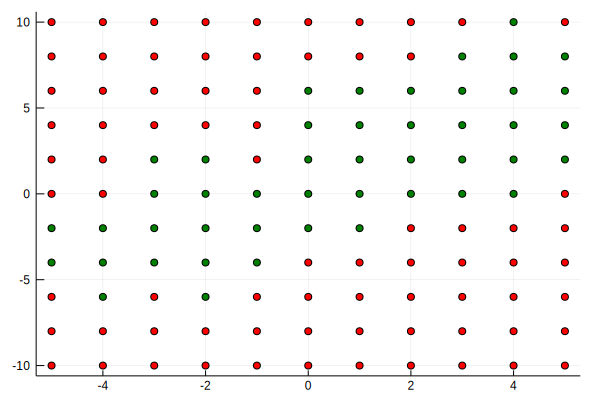

In [34]:
plt = plot(legend=false)
for row in eachrow(table)
    if row[:controller] == "net_mpc"
        success = -π/4 <= row[:qf][3] <= π/4
        scatter!(plt, [row[:v0][1]], [row[:v0][3]], color = success ? "green" : "red")
    end
end
plt

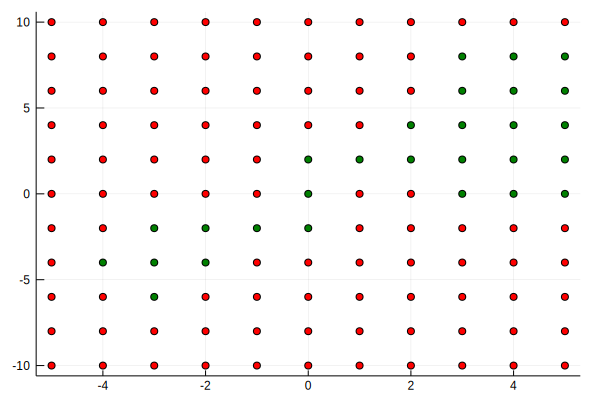

In [35]:
plt = plot(legend=false)
for row in eachrow(table)
    if row[:controller] == "lqr_mpc"
        success = -π/4 <= row[:qf][3] <= π/4
        scatter!(plt, [row[:v0][1]], [row[:v0][3]], color = success ? "green" : "red")
    end
end
plt